In [ ]:
import pandas as pd

In [49]:
#import data
df = pd.read_csv('data\\Training.csv')


In [52]:
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [51]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [165]:
#train test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

xtrain, xtest, ytrain, ytest = train_test_split(X, y_encoded , test_size = 0.4, random_state = 12)

In [183]:
#convert to tensors
xtrain_tensor = torch.tensor(xtrain, dtype = torch.float32)
ytrain_tensor = torch.tensor(ytrain, dtype = torch.long)
xtest_tensor = torch.tensor(xtest, dtype = torch.float32)
ytest_tensor = torch.tensor(ytest, dtype = torch.long)


In [184]:
# create torch tensor dataset and loader

from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(xtrain_tensor, ytrain_tensor)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)

train_loader = DataLoader(train_ds, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_ds , batch_size = 32 , shuffle = True)



In [168]:
xtrain_tensor.shape, ytrain_tensor.shape

(torch.Size([2952, 132]), torch.Size([2952]))

In [220]:
import torch
import torch.nn as nn

class FFNN(nn.Module):
    def __init__(self,input_size, output_size, hidden_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, output_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        out1 = self.fc1(x)
        out2 = self.relu(out1)
        out3 = self.fc2(out2)
        out4 = self.fc3(out3)
        out = self.softmax(out4)
        
        return out
        

    
    

In [58]:
len(le.classes_)

41

In [221]:
input_s = xtrain.shape[1]
output_s = len(le.classes_)
hidden_layers = 64
model = FFNN(input_s,output_s,hidden_layers)
model

FFNN(
  (fc1): Linear(in_features=132, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=41, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [68]:
input1 = torch.rand((1,132))
output = model(input1)
output.shape

torch.Size([1, 41])

In [222]:
# define loss function, optimizers etc

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# # learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Log the learning rate
# learning_rates = []

In [223]:

epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, epochs, epoch_loss))


Epoch [1/20], Loss: 3.6554
Epoch [2/20], Loss: 3.1380
Epoch [3/20], Loss: 2.7862
Epoch [4/20], Loss: 2.7607
Epoch [5/20], Loss: 2.7576
Epoch [6/20], Loss: 2.7565
Epoch [7/20], Loss: 2.7559
Epoch [8/20], Loss: 2.7556
Epoch [9/20], Loss: 2.7553
Epoch [10/20], Loss: 2.7552
Epoch [11/20], Loss: 2.7551
Epoch [12/20], Loss: 2.7550
Epoch [13/20], Loss: 2.7550
Epoch [14/20], Loss: 2.7549
Epoch [15/20], Loss: 2.7549
Epoch [16/20], Loss: 2.7548
Epoch [17/20], Loss: 2.7548
Epoch [18/20], Loss: 2.7548
Epoch [19/20], Loss: 2.7548
Epoch [20/20], Loss: 2.7548


In [224]:
# Evaluation loop (for test data)

test_losses = []
epochs = 20
for epoch in range(epochs):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print("Epoch [{}/{}], Test Loss: {:.4f}".format(epoch + 1, epochs, test_loss))

Epoch [1/20], Test Loss: 2.7548
Epoch [2/20], Test Loss: 2.7548
Epoch [3/20], Test Loss: 2.7548
Epoch [4/20], Test Loss: 2.7548
Epoch [5/20], Test Loss: 2.7548
Epoch [6/20], Test Loss: 2.7548
Epoch [7/20], Test Loss: 2.7548
Epoch [8/20], Test Loss: 2.7548
Epoch [9/20], Test Loss: 2.7548
Epoch [10/20], Test Loss: 2.7548
Epoch [11/20], Test Loss: 2.7548
Epoch [12/20], Test Loss: 2.7548
Epoch [13/20], Test Loss: 2.7548
Epoch [14/20], Test Loss: 2.7548
Epoch [15/20], Test Loss: 2.7548
Epoch [16/20], Test Loss: 2.7548
Epoch [17/20], Test Loss: 2.7548
Epoch [18/20], Test Loss: 2.7548
Epoch [19/20], Test Loss: 2.7548
Epoch [20/20], Test Loss: 2.7548


In [215]:
test_losses

[2.754755615218868]

In [211]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the model on the test data: {100 * correct / total:.2f}%')


Accuracy of the model on the test data: 100.00%


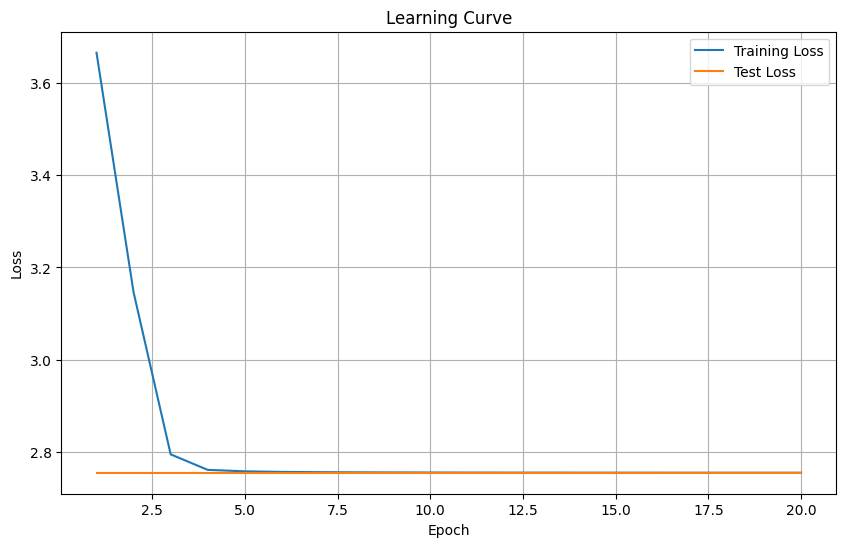

In [219]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# epochs = 10
# actuals = []

# for i in range(epochs):
#     model.train()
#     for inputs, labels in train_loader:
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
# #     # Log the learning rate
# #     learning_rates.append(optimizer.param_groups[0]['lr'])
    
# #     # Step the learning rate scheduler
# #     scheduler.step() 

# #     prediction = outputs.argmax(dim=1, keepdim=True)
# #     actuals.extend(labels)
# #     probabilities.extend(outputs.squeeze(-1).detach().numpy())

#     print(" Epoch [{}/{}], Loss : {}".format(i+1,epochs, loss.item()))

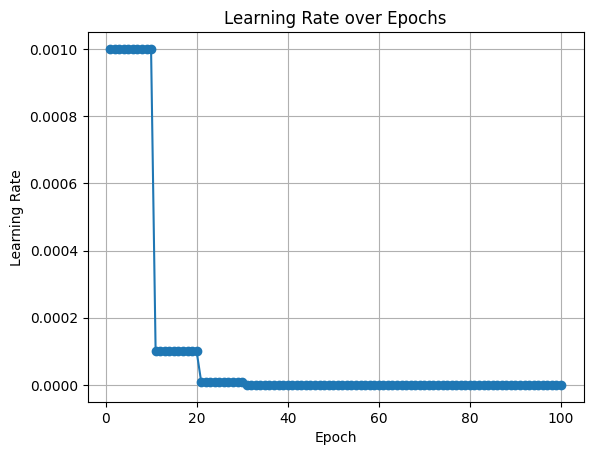

In [89]:
import matplotlib.pyplot as plt
# Plot the learning rates
plt.plot(range(1, epochs + 1), learning_rates, marker='o')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


Accuracy of the model on the test data: 100.00%


In [105]:
# from sklearn.metrics import roc_curve, auc

# n_classes = y_pred.shape[1]  # Get number of classes

# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(xtrain)):
#     # Separate class i labels from the rest
#     y_true = y_test[:, i]
#     y_score = y_pred[:, i]

#     # Calculate ROC curve for class i vs rest
#     fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
#     roc_auc[i] = auc(fpr[i], tpr[i])


In [117]:
probabilites = model(xtrain_tensor)
y_score = probabilites.squeeze(-1).detach().numpy()
# fpr, tpr, threshold = roc_curve(y_encoded, y_score)

In [140]:
probabilites


tensor([[3.9620e-14, 1.1440e-08, 2.5492e-19,  ..., 1.6941e-10, 4.0718e-11,
         5.3803e-19],
        [6.2591e-18, 2.2794e-17, 1.9202e-24,  ..., 1.2811e-17, 2.1321e-21,
         1.8100e-20],
        [4.1231e-13, 4.6214e-17, 3.1598e-21,  ..., 1.3396e-22, 3.8767e-21,
         3.2978e-11],
        ...,
        [1.9302e-14, 6.3155e-13, 1.3982e-11,  ..., 1.9945e-11, 1.1436e-14,
         9.2060e-11],
        [7.1144e-19, 1.6301e-13, 4.3639e-13,  ..., 5.3873e-12, 3.6332e-14,
         1.4710e-17],
        [2.3943e-10, 8.2087e-15, 3.4761e-21,  ..., 2.2763e-09, 5.2139e-13,
         1.4728e-23]], grad_fn=<SoftmaxBackward0>)

Random Forest

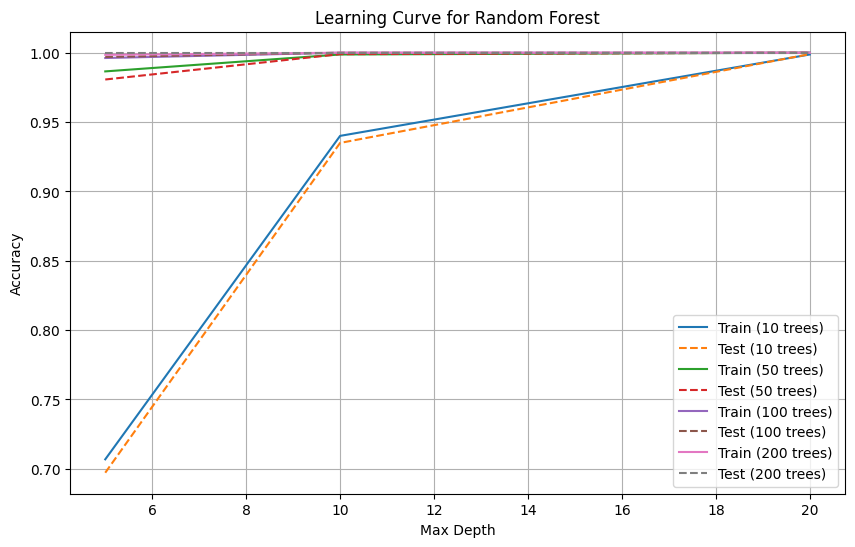

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming 'X' is your feature matrix and 'y' is your target vector

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of values for the number of trees and max depth
n_estimators_values = [10, 50, 100, 200]
max_depth_values = [None, 5, 10, 20]

# Initialize lists to store the accuracies
train_accuracies = []
test_accuracies = []

# Iterate over different values for number of trees and max depth
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        # Initialize the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
        # Train the classifier
        rf_classifier.fit(X_train, y_train)
        
        # Make predictions on the train and test sets
        y_train_pred = rf_classifier.predict(X_train)
        y_test_pred = rf_classifier.predict(X_test)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Append accuracies to the lists
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

# Reshape the lists into arrays
train_accuracies = np.array(train_accuracies).reshape(len(n_estimators_values), len(max_depth_values))
test_accuracies = np.array(test_accuracies).reshape(len(n_estimators_values), len(max_depth_values))

# Plot the learning curve
plt.figure(figsize=(10, 6))
for i, n_estimators in enumerate(n_estimators_values):
    plt.plot(max_depth_values, train_accuracies[i], label='Train ({} trees)'.format(n_estimators))
    plt.plot(max_depth_values, test_accuracies[i], label='Test ({} trees)'.format(n_estimators), linestyle='--')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()


CatBoost

In [161]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=2, loss_function='MultiClass', verbose=False)
model.fit(xtrain, ytrain)

predictions = model.predict(xtest)
accuracy = accuracy_score(ytest, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9908536585365854


In [162]:
df.duplicated().sum()

4616

In [163]:
len(df) # oops

4920

In [3]:
class A:
    def __init__(self):
        print("A's __init__")

class B(A):
    def __init__(self):
        super().__init__()
        print("B's __init__")

class C(A):
    def __init__(self):
        super().__init__()
        print("C's __init__")

class D(B, C):
    def __init__(self):
        super().__init__()
        print("D's __init__")

d = D()

A's __init__
C's __init__
B's __init__
D's __init__
